In [1]:
import tensorflow as tf
import numpy as np
import time
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from IcGanLayer import gan_loss, classify_loss, generator
from dataset_and_utils import prepare_datasets, show_image, list_devices, prepare_new_datasets, save_image

In [2]:
n_classes = 309
batch_size = 32

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
config.log_device_placement=True
config.allow_soft_placement=True

In [3]:
train_dataset, val_dataset, test_dataset = prepare_new_datasets(batch_size)



Duration is 34.996307611465454
Duration is 7.363466262817383
Duration is 7.660866975784302


In [ ]:
tf.reset_default_graph()
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, 64, 64,  3], name='x')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')
    
    
    loss_pred, loss_gen, gen = gan_loss(x, y, n_classes)
    loss_cls, Ey = classify_loss(x, y, n_classes)
    
    evaluate = tf.equal(tf.round(Ey), y)
    accuracy = tf.reduce_mean(tf.cast(evaluate,dtype=tf.float32))
    
    saver = tf.train.Saver()
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        pred_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(loss_pred)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(loss_gen)
        cls_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(loss_cls)
    

In [ ]:
n_epoch = 100
halve_lr_every = 20
test_every = 20
save_model_every = 1
lr = 2 * 10-4

# train_iterator = train_dataset.make_initializable_iterator()
# val_iterator = val_dataset.make_initializable_iterator()
train_iterator = train_dataset.make_one_shot_iterator()
next_batch_data = train_iterator.get_next()

val_iterator = val_dataset.make_one_shot_iterator()
next_batch_val = val_iterator.get_next()


#with tf.Session(config=config) as sess:
sess = tf.InteractiveSession(config=config)
init = tf.global_variables_initializer()
sess.run(init)
# sess.run(train_iterator.initializer, feed_dict={max_value: 32})
# sess.run(val_iterator.initializer)
since = time.time()
epoch = 0
pred_cost = 0.
gen_cost = 0.

iter_cnt = 0
batch_cnt = 0
while(epoch < n_epoch):
    iter_cnt += 1
    
    while True:
        try:
            print(batch_cnt)
            print(time.time() - since)
            imgs, labs = sess.run(next_batch_data)
            batch_cnt += 1
            print(time.time() - since)
            _, _, pred_cost, gen_cost = sess.run([pred_optimizer, gen_optimizer, loss_pred, loss_gen],
                                         feed_dict={x:imgs, y:labs, learning_rate:lr})
            print(time.time() - since)
            print('\n')
    
       
        except tf.errors.OutOfRangeError:
            train_iterator = train_dataset.make_one_shot_iterator()
            next_batch_data = train_iterator.get_next()
            break
            
    if (epoch+1) % test_every == 0:
        try:
            imgs, labs = sess.run(next_batch_val)
        except:
            val_iterator = val_dataset.make_one_shot_iterator()
            next_batch_val = val_iterator.get_next()
            imgs, labs = sess.run(next_batch_val)

        val_image = sess.run([gen], feed_dict={x:imgs, y:labs, learning_rate:lr})

        show_image(imgs[1])
        val_image = np.array(val_image)
        show_image(np.squeeze(val_image)[1])

    if (epoch+1) % save_model_every == 0:
        saver.save(sess, 'model/IcGan_'+str(epoch+1)+'_epochs')

    if (epoch+1) % halve_lr_every:
        lr /= 2
    
    epoch += 1
    uptime = time.time() - since
    print('Iter {} {}m:{}s -- discriminator loss: {}, generator loss: {}'.format(epoch+1, uptime//60, uptime%60,
                                                                                     pred_cost, gen_cost))


        
            
# while(epoch < n_epoch):
#     iter_cnt += 1
#     print(iter_cnt)
#     print(time.time() - since)
#     try:
#         imgs, labs = sess.run(next_batch_data)
# #         if imgs.shape[0] != batch_size:
# #             raise Exception
#     except:
#         train_iterator = train_dataset.make_one_shot_iterator()
#         next_batch_data = train_iterator.get_next()
#         imgs, labs = sess.run(next_batch_data)
#         epoch += 1
        
#         uptime = time.time() - since
#         print('Iter {} {}m:{}s -- discriminator loss: {}, generator loss: {}'.format(epoch+1, uptime//60, uptime%60,
#                                                                                      pred_cost, gen_cost))
#         if (epoch+1) % test_every == 0:
#             try:
#                 imgs, labs = sess.run(next_batch_data)
# #                 if imgs.shape[0] != batch_size:
# #                     raise Exception
#             except:
#                 train_iterator = train_dataset.make_one_shot_iterator()
#                 next_batch_data = train_iterator.get_next()
#                 imgs, labs = sess.run(next_batch_data)

#             val_image = sess.run([gen], feed_dict={x:imgs, y:labs, learning_rate:lr})

#             show_image(imgs[1])
#             val_image = np.array(val_image)
#             show_image(np.squeeze(val_image)[1])

#         if (epoch+1) % save_model_every == 0:
#             saver.save(sess, 'model/IcGan_'+str(epoch+1)+'_epochs')

#         if (epoch+1) % halve_lr_every:
#             lr /= 2
      
#     print(time.time() - since)
#     _, _, pred_cost, gen_cost = sess.run([pred_optimizer, gen_optimizer, loss_pred, loss_gen],
#                                          feed_dict={x:imgs, y:labs, learning_rate:lr})
#     print(time.time() - since)
#     print('\n')
    


saver.save(sess, 'model/IcGan_final_model')

0
0.0006611347198486328
0.8198096752166748
2.686732530593872


1
2.687382221221924
2.6880879402160645
2.767406463623047


2
2.7680461406707764
2.76882004737854
2.845505475997925


3
2.845914840698242
2.846745252609253
2.922210693359375


4
2.9223790168762207
2.9228732585906982
2.9954137802124023


5
2.9956114292144775
2.9964075088500977
3.069312572479248


6
3.0697343349456787
3.0703628063201904
3.142897129058838


7
3.1431455612182617
3.1439661979675293
3.2155921459198


8
3.21610689163208
3.216813802719116
3.2886297702789307


9
3.288989305496216
3.289466619491577
3.361862897872925


10
3.3624792098999023
3.3630788326263428
3.4348502159118652


11
3.4354145526885986
3.436095952987671
3.5079379081726074


12
3.508392333984375
3.5089848041534424
3.5813822746276855


13
3.582059621810913
3.5828099250793457
3.65519380569458


14
3.655744791030884
3.656397581100464
3.7281394004821777


15
3.72853422164917
3.7292582988739014
3.8014233112335205


16
3.8015708923339844
3.802081823348999
3.87

12.796525478363037


139
12.796735286712646
12.79763913154602
12.870132207870483


140
12.870317697525024
12.87083125114441
12.94235897064209


141
12.942476987838745
12.943133354187012
13.015385389328003


142
13.01591181755066
13.016523122787476
13.089811563491821


143
13.090385913848877
13.091066837310791
13.162343740463257


144
13.162534236907959
13.163379669189453
13.234986543655396


145
13.235623836517334
13.236373901367188
13.30894660949707


146
13.309062004089355
13.30959177017212
13.3821861743927


147
13.382298707962036
13.3830246925354
13.454530000686646


148
13.454684019088745
13.45560359954834
13.52751088142395


149
13.52782416343689
13.528701543807983
13.600530862808228


150
13.601234912872314
13.602106809616089
13.67492389678955


151
13.675481796264648
13.676131963729858
13.748199939727783


152
13.74872374534607
13.749326944351196
13.82089376449585


153
13.821332454681396
13.821874380111694
13.894098043441772


154
13.894608736038208
13.895232200622559
13.96731

22.504010438919067


271
22.5048725605011
22.505735158920288
22.578290462493896


272
22.578491687774658
22.579350233078003
22.651731491088867


273
22.652225732803345
22.653017044067383
22.724482536315918


274
22.724798679351807
22.725560903549194
22.797343492507935


275
22.797727823257446
22.798465251922607
22.870923280715942


276
22.87122917175293
22.871898651123047
22.94477128982544


277
22.94564127922058
22.94662380218506
23.018693923950195


278
23.018832206726074
23.019810438156128
23.097301483154297


279
23.09758424758911
23.099807739257812
23.172993659973145


280
23.17316222190857
23.174057483673096
23.2461097240448


281
23.246217489242554
23.247272968292236
23.3192720413208


282
23.31982445716858
23.32057523727417
23.39859962463379


283
23.39881944656372
23.399876356124878
23.47237753868103


284
23.473288536071777
23.474080562591553
23.546785593032837


285
23.54754114151001
23.548256397247314
23.620177507400513


286
23.62091374397278
23.62143111228943
23.692855358

32.35218572616577


406
32.35268568992615
32.35332465171814
32.42495918273926


407
32.42541456222534
32.4260618686676
32.49799847602844


408
32.49861741065979
32.499347448349
32.57163596153259


409
32.572102308273315
32.57270336151123
32.6449511051178


410
32.64539432525635
32.64606308937073
32.71748447418213


411
32.717987060546875
32.718700885772705
32.78960371017456


412
32.78980898857117
32.79036092758179
32.8616578578949


413
32.86202549934387
32.86248469352722
32.93366026878357


414
32.93407154083252
32.93467307090759
33.00629997253418


415
33.00684142112732
33.00742769241333
33.07862162590027


416
33.07909154891968
33.079777002334595
33.15178894996643


417
33.1525092124939
33.15319609642029
33.22496819496155


418
33.225499868392944
33.22617959976196
33.297489643096924


419
33.29804873466492
33.29871702194214
33.37023878097534


420
33.37082386016846
33.37149906158447
33.44303274154663


421
33.443578243255615
33.444270610809326
33.515997648239136


422
33.5165135860

42.1765615940094


541
42.17672276496887
42.177369594573975
42.248594760894775


542
42.24882888793945
42.24935293197632
42.3208281993866


543
42.321189641952515
42.3227322101593
42.394827127456665


544
42.39547514915466
42.39604663848877
42.4674186706543


545
42.46763586997986
42.468140840530396
42.53948640823364


546
42.5399215221405
42.54062056541443
42.61251187324524


547
42.613338470458984
42.61420822143555
42.68615984916687


548
42.68650245666504
42.68719720840454
42.75923156738281


549
42.75955319404602
42.76024508476257
42.83198595046997


550
42.83228302001953
42.83297538757324
42.90424609184265


551
42.904752016067505
42.90528845787048
42.97680926322937


552
42.97730827331543
42.97797250747681
43.04977369308472


553
43.05025672912598
43.05078840255737
43.12201285362244


554
43.12240433692932
43.12303423881531
43.19496965408325


555
43.19575643539429
43.19658660888672
43.26876950263977


556
43.26925206184387
43.26985430717468
43.341432332992554


557
43.3418157100

52.237242221832275


679
52.23758268356323
52.23810172080994
52.30934476852417


680
52.30985236167908
52.31040811538696
52.381526947021484


681
52.381972312927246
52.382615089416504
52.45474982261658


682
52.455384969711304
52.456228733062744
52.52797818183899


683
52.528528451919556
52.52922177314758
52.601582527160645


684
52.6020610332489
52.60270857810974
52.67475867271423


685
52.675256967544556
52.67580199241638
52.74761080741882


686
52.748053312301636
52.74855160713196
52.82012581825256


687
52.82033038139343
52.820884227752686
52.89305877685547


688
52.89361929893494
52.89420223236084
52.965657234191895


689
52.96607685089111
52.96679091453552
53.039557695388794


690
53.04004907608032
53.040608167648315
53.11199426651001


691
53.11258244514465
53.11307692527771
53.1842041015625


692
53.184568881988525
53.184943199157715
53.256428480148315


693
53.25678777694702
53.25739073753357
53.32909393310547


694
53.32968759536743
53.330323934555054
53.40291714668274


695


62.31011629104614


817
62.310489654541016
62.31196069717407
62.384565591812134


818
62.38493847846985
62.38559007644653
62.45788216590881


819
62.458178997039795
62.4590699672699
62.532177686691284


820
62.53245306015015
62.533087730407715
62.60500168800354


821
62.60536170005798
62.605947494506836
62.67751145362854


822
62.67761993408203
62.678112268447876
62.74966025352478


823
62.74987530708313
62.75060248374939
62.822267293930054


824
62.822667837142944
62.823368310928345
62.895118951797485


825
62.89526081085205
62.896202087402344
62.96900010108948


826
62.969597816467285
62.97038912773132
63.04206943511963


827
63.0423264503479
63.043055057525635
63.115310192108154


828
63.115397453308105
63.11596155166626
63.18672299385071


829
63.186835289001465
63.18741726875305
63.2588427066803


830
63.25899839401245
63.25956416130066
63.33149600028992


831
63.33185601234436
63.33245658874512
63.40380644798279


832
63.40445923805237
63.40517854690552
63.47782921791077


833
63

72.34520292282104


955
72.34550094604492
72.34596920013428
72.41783022880554


956
72.41841101646423
72.41902279853821
72.49022436141968


957
72.49057292938232
72.49121522903442
72.56275033950806


958
72.56330633163452
72.56385850906372
72.63571119308472


959
72.63618230819702
72.63681173324585
72.70812344551086


960
72.70856261253357
72.70907640457153
72.7815523147583


961
72.78197813034058
72.78242921829224
72.85387825965881


962
72.85415625572205
72.85484313964844
72.92612338066101


963
72.92650938034058
72.92707824707031
72.99870014190674


964
72.99895787239075
72.99956178665161
73.07083988189697


965
73.07126903533936
73.0717236995697
73.14400362968445


966
73.1441068649292
73.14478349685669
73.2161328792572


967
73.21672987937927
73.21730017662048
73.28871059417725


968
73.28918600082397
73.28984665870667
73.36192679405212


969
73.36237144470215
73.36288118362427
73.43481802940369


970
73.43537616729736
73.4359519481659
73.50742769241333


971
73.5076551437378
73.5

In [8]:
sess.close()

NameError: name 'sess' is not defined

In [23]:
for it in range(10):
    try:
        imgs, labs = sess.run(train_iterator.get_next())
    except:
        train_iterator = train_dataset.make_one_shot_iterator()
        imgs, labs = sess.run(train_iterator.get_next())

RuntimeError: Attempted to use a closed Session.

In [ ]:
n_iters = 500
print_every = 100
test_every = 100

#with tf.Session(config=config) as sess:
sess = tf.InteractiveSession(config=config)
init = tf.global_variables_initializer()
sess.run(init)

since = time.time()
for it in range(n_iters):
    cur_x, cur_y = train_dataset.next_batch(batch_size)

    _, _, pred_cost, gen_cost = sess.run([pred_optimizer, gen_optimizer, loss_pred, loss_gen], feed_dict={x:cur_x, y:cur_y})

    if (it+1) % print_every == 0:
        uptime = time.time() - since
        print('Iter {} {}m:{}s -- discriminator loss: {}, generator loss: {}'.format(it+1, uptime//60, uptime%60,
                                                                           pred_cost, gen_cost))
    
    if (it+1) % test_every == 0:
        cur_x, cur_y = train_dataset.next_batch(2)
        test_image = sess.run([gen], feed_dict={x:cur_x, y:cur_y})

        show_image(cur_x[1])
        test_image = np.array(test_image)
        show_image(np.squeeze(test_image)[1])

saver.save(sess, 'model/testmodel')

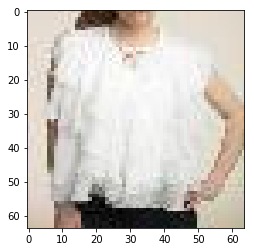

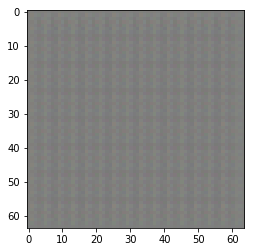

In [9]:
cur_x, cur_y = train_dataset.next_batch(2)
test_image = sess.run([gen], feed_dict={x:cur_x, y:cur_y})


show_image(cur_x[1])
test_image = np.array(test_image)
show_image(np.squeeze(test_image)[1])



In [15]:
test_image = np.array(test_image)
print(test_image)
show_image(np.squeeze(test_image)[0])

[[[[[ 0.01731281 -0.00049786 -0.00051697]
    [ 0.0268098  -0.02541385  0.01045074]
    [ 0.02335242 -0.00472535  0.000988  ]
    ..., 
    [ 0.02309056 -0.0233418   0.00030125]
    [ 0.01858981 -0.00071221 -0.00074584]
    [ 0.00630514 -0.00156878 -0.00217882]]

   [[ 0.01544815 -0.00251214  0.00103776]
    [ 0.02088345  0.0127382  -0.02702123]
    [ 0.02707589  0.04212866 -0.0209272 ]
    ..., 
    [ 0.01083681  0.00754928 -0.02845698]
    [ 0.02097915  0.04105031 -0.02113053]
    [ 0.02737332  0.0151865   0.0047413 ]]

   [[ 0.02455161 -0.00475989 -0.01290123]
    [ 0.04648749 -0.00521686 -0.00242949]
    [ 0.02918772  0.04352136  0.00890721]
    ..., 
    [ 0.04670377  0.00393848 -0.01058939]
    [ 0.01506993  0.04881216  0.00720783]
    [ 0.00852257 -0.00583907  0.00246301]]

   ..., 
   [[ 0.02219488  0.00472032  0.00305387]
    [ 0.01431249  0.00610014 -0.02272281]
    [ 0.03196518  0.03460883 -0.02070677]
    ..., 
    [ 0.01392783  0.00794118 -0.02172735]
    [ 0.02281539  0.0

ValueError: Floating point image RGB values must be in the 0..1 range.

In [ ]:
with tf.Session(config=config) as sess:
    for epoch in range(n_iters):
        cls_cost = sess,run([cls_optimizer], feed_dict={x:dataset.nextbatch(), y:label.nextbatch()})
        print('classifer loss: %f, accuracy: %f' % (cls_cost, accuracy.eval()))
    saver.save(sess, 'save/to/path')
        

In [ ]:
'''
#         try:
#             imgs, labs = sess.run(val_dataset.get_next())
#             if imgs.shape[0] != batch_size:
#                 raise Exception
#         except:
#             val_iterator = val_dataset.make_one_shot_iterator()
#             imgs, labs = sess.run(val_dataset.get_next())

img_dir = 'img_10000/training_{}'.format((it+1) // test_every)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    for i in range(5):
        save_image(imgs[i], img_dir+'/origin_{}'.format(i))
        save_image(np.squeeze(val_image)[i], img_dir+'/pred_{}'.format(i))

'''